<a href="https://colab.research.google.com/github/rohitgarg025/dl_assignment_1/blob/main/DLASSGN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS F425 Deep Learning: Lab Assignment 1
## Submitted by :
1. Somesh Singh [2018A7PS0175G]
2. Rohit Garg [2018A7PS0193G]
3. Aditya Mishra [2018A7PS0117G]

## MLP

We trained multi-layer perceptron (MLP) model on CIFAR and MNIST dataset. On increasing the number of layers, we observed the following issues: 
1. Degradation Problem : As the depth of the network increased, we observed a decline in training accuracy and increase in loss.
2. Vanishing and Exploding Gradients problem : Means that gradients of loss become more and more muted in the beginning layers of a network as the network become increasingly deeper. 
3. Non-convexity of loss surface with chaotic behaviour.

Clearly, increasing the number of layers did not lead to expected phenomenon of overfitting.

#Experiment 1: Effect of Number of Layers on MLP
Validation Accuracies of different models with 4, 6 and 10 layers (MNIST)

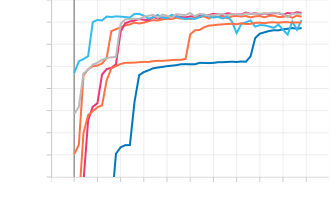

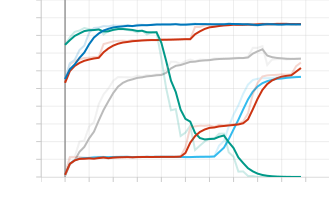

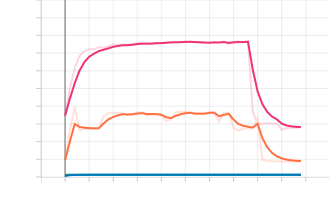


## Why Skip Connections?

We overcame the short-comings of MLP network by use of Skip connections or shortcut connections. It was observed that Skip connections improved both train ing and test accuracy and loss .Even with more number of layers skip connections were able to converge better. Thus, skip connections improved helped us solve degradation problem and in feature reusability

## Structure of MLP, Additive Skip Connection and Concatenative Skip Connections

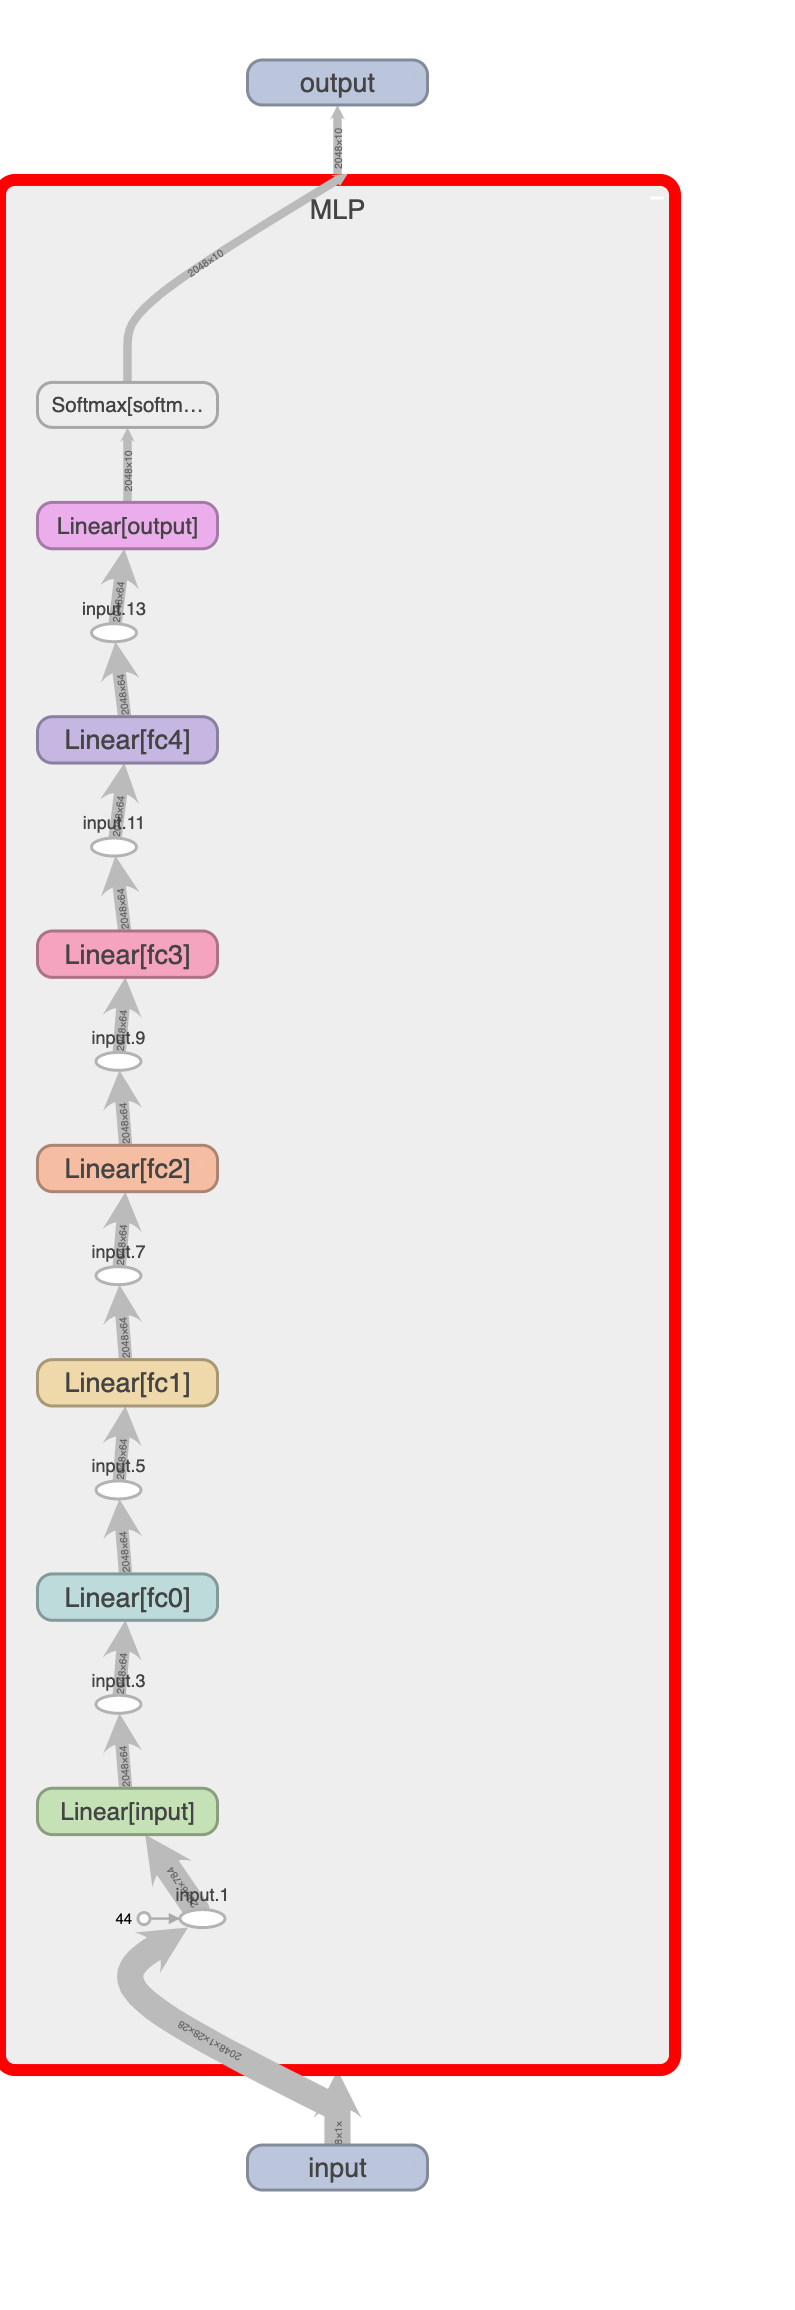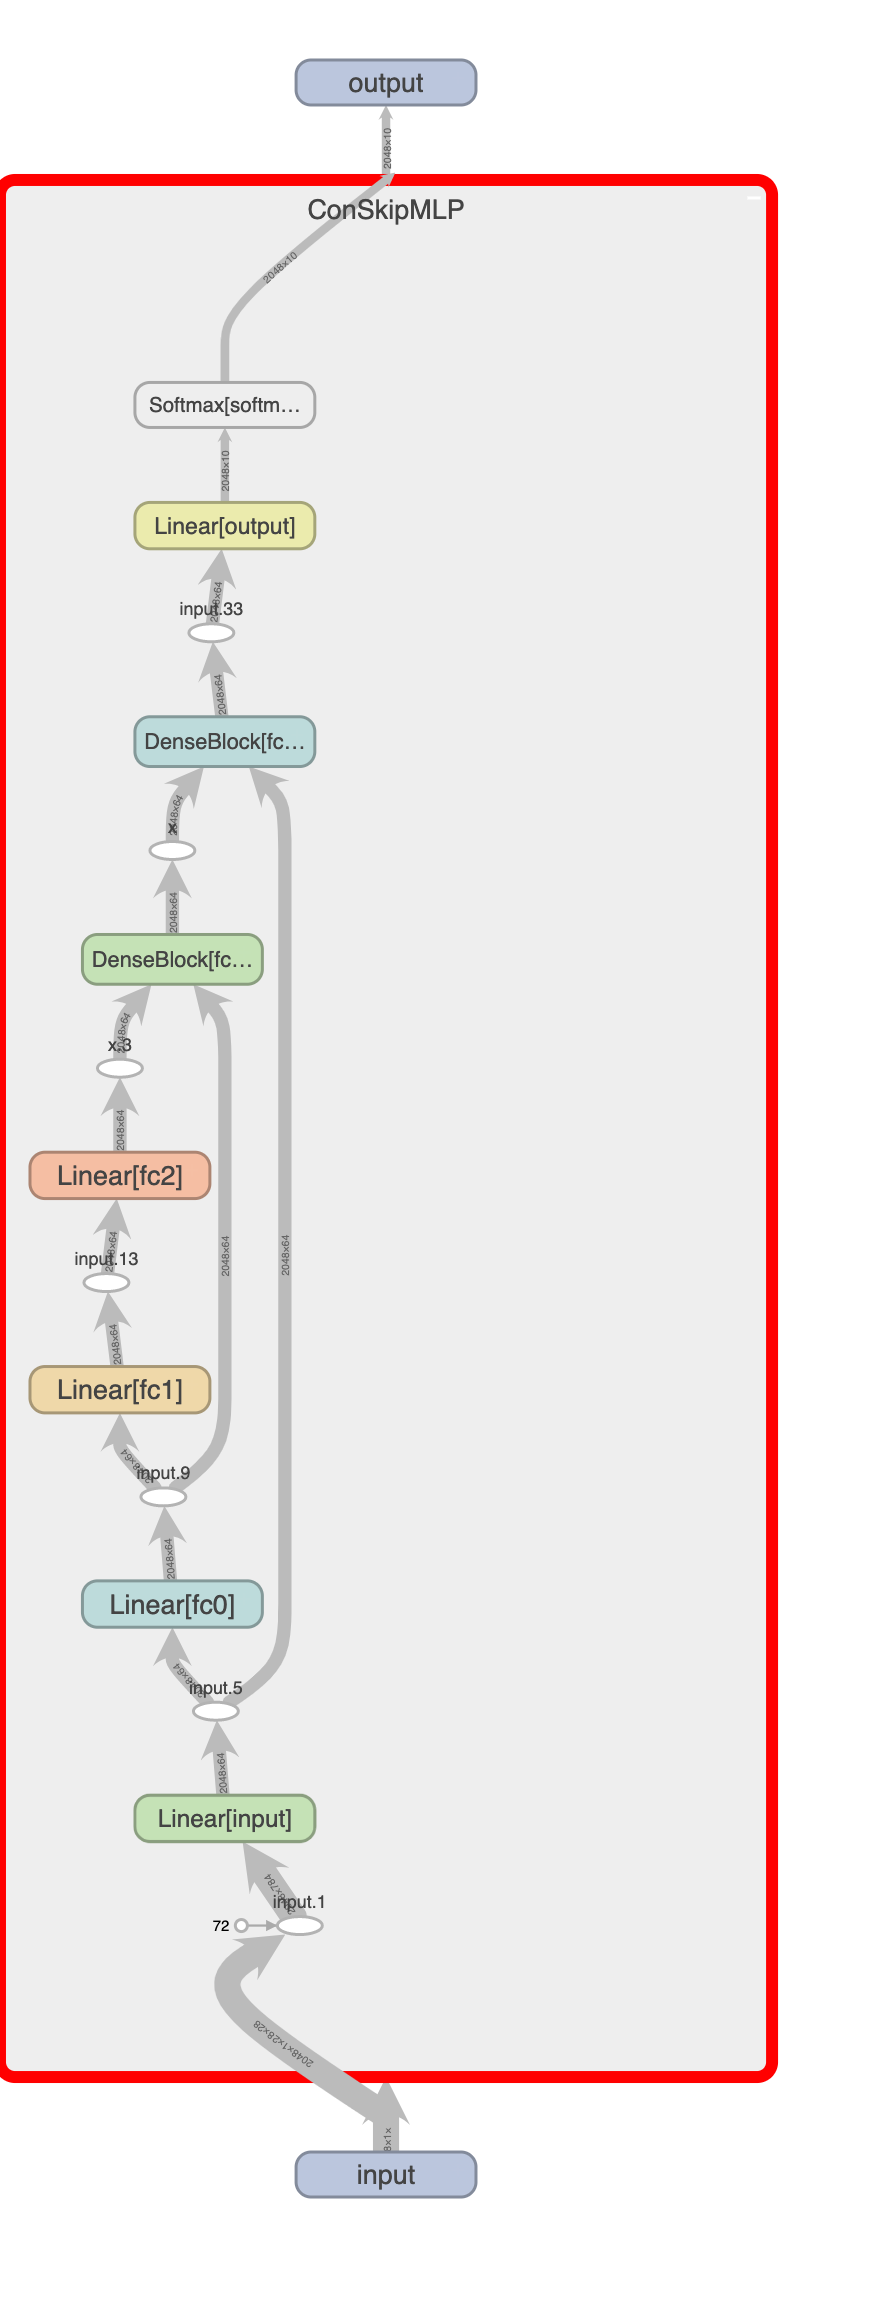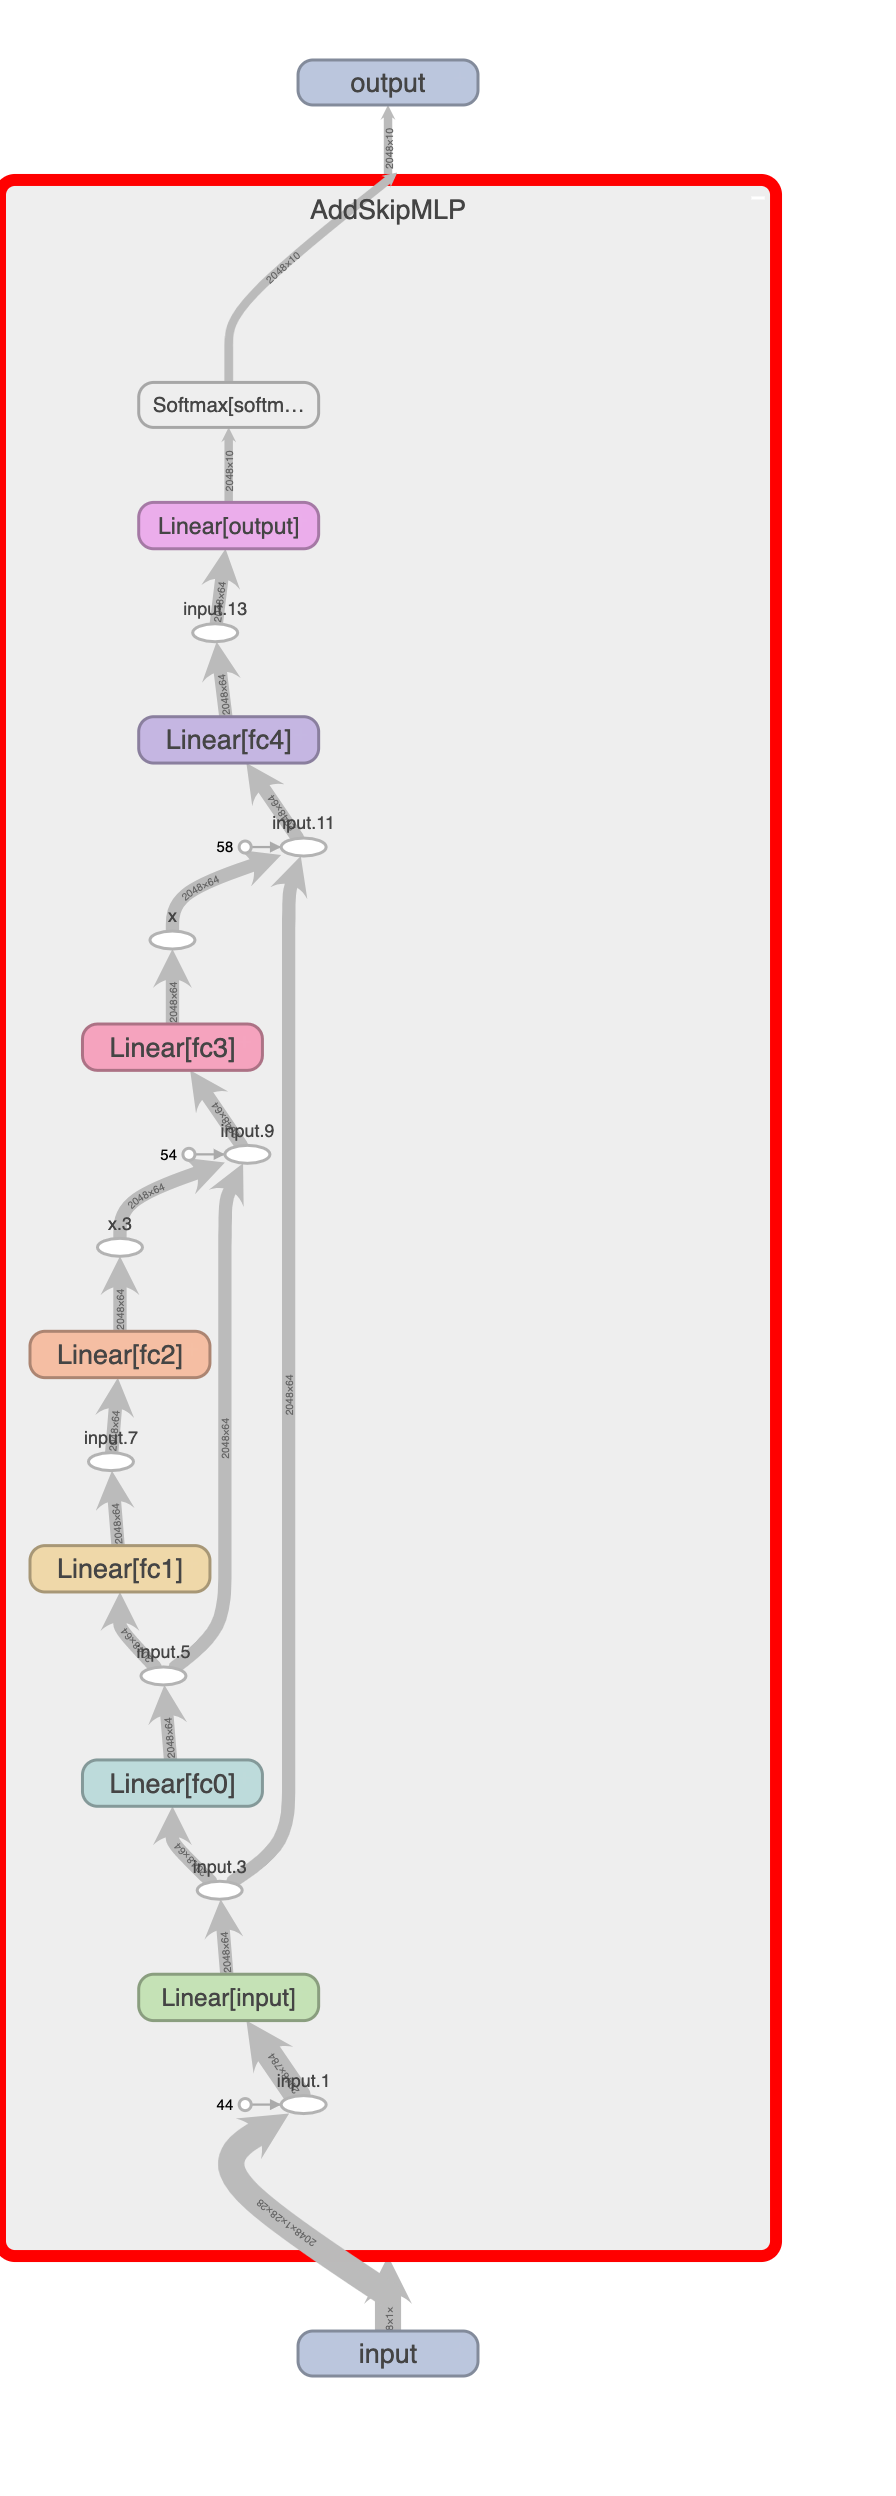

## Analysis of different types of Skip Connections
1. Additive Skip Connection:
    
    * The core idea is to backpropagate through the identity function, by just using a vector addition. 
The gradient would simply be multiplied by one and its value will be maintained in the earlier layers. 
Stacking these skip residual blocks together, use an identity function to preserve the gradient.

    * It has been observed that in earlier layers the learned features correspond to lower semantic information that is extracted from the input. If we had not used the skip connection
that information would have turned too abstract. 
nax-dsft-inm

2. Concatenation Skip Connection
    * The idea behind the concatenation skip is to use features that are learned from earlier layers in deeper layers as well. 
    * Architectures with concatenated skip-connections, allow the subsequent layers to re-use middle representations, maintaining more information which can lead to better performances.

# Additive Skip Connections to 6 and 10 Layer Models

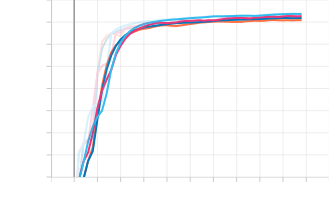

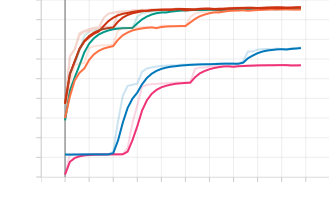

# Concat Skip Connections to 6 and 10 Layer Models

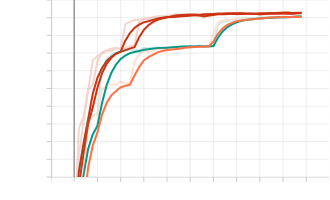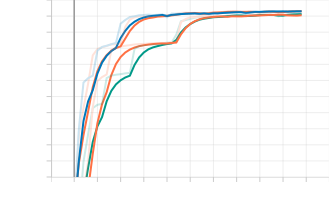

#Experiment 1: Effect of Number of Layers on MLP
Validation Accuracies of different models with 6 and 10 layers (CIFAR)

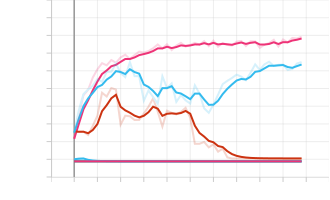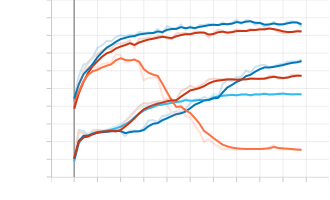

# Additive Skip Connections to 6 and 10 Layer Models

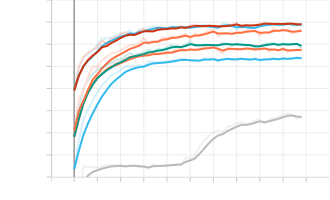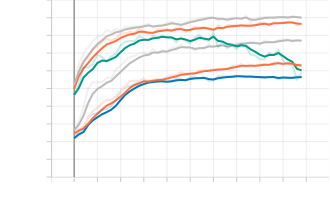



# Concat Skip Connections to 6 and 10 Layer Models

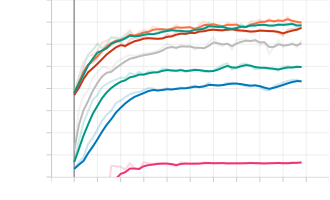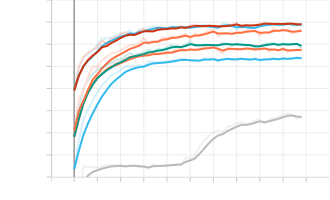

## Ablation Studies
During ablation studies of a skip connection [additive and concatenation], we tuned the following parameters:
1. Number of layers skipped by a connection
2. Number of skip connections added to vanilla MLP

With varying
1. Activation Function [ReLU, Sigmoid]
2. Depth [4,6,10]
3. Width [64,128,512]

#CIFAR Number of Skips Additive, Concatanative

Performance of MLP is linearly proportional to the number of layers skipped

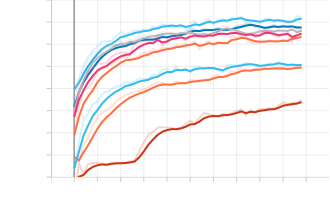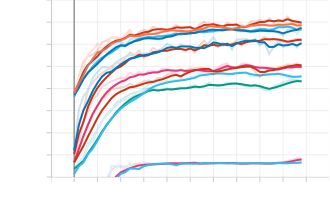

#MNIST Number of Skips Additive, Concatanative

Performance of MLP is linearly proportional to the number of layers skipped (9, 7 , 4 in order)

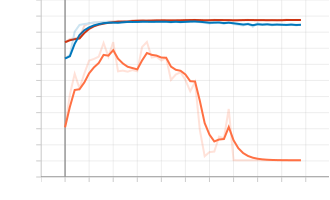

#Skipping More Layers gets better results, following are results of skipping 1, 2, 3 times in the same connections across MNIST and CIFAR

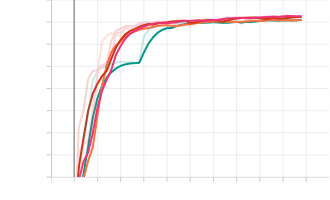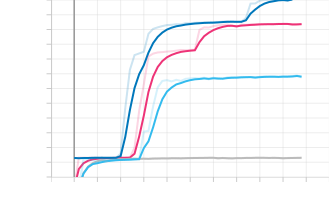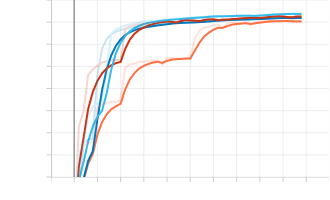

#Skipping More Layers solves the vanishing and exploding gradients as well

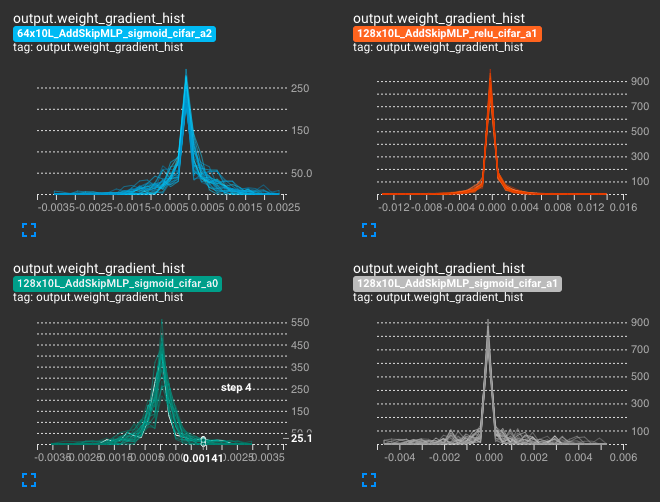

## Some Observations : 
1. ReLU activation gave better accuracy than sigmoid as sigmoid activation function as it undergo vanishing gradients problem in many runs.
2. We overcame the shortcumings of MLP network by use of Skip connections or shortcut connections.
3. On increasing width of the network, the training and test accuracy of the network improved [From 64 to 128 neurons]. However, we increasing it above certain threshold, we noticed exploding gradients problem[at 512 neurons per layer].
4. During ablation stuides of skip connections, on increasing the number of layers skipped we see an increase in training accuracy on an average. This is because of enhanced gradient flow through identity path.
5. Connecting initial and last layers gave better results than adding skip connections in between part.

# Histo gram comparisions for gradients for MLP vs MLP with Skip comparison with 10 Layers

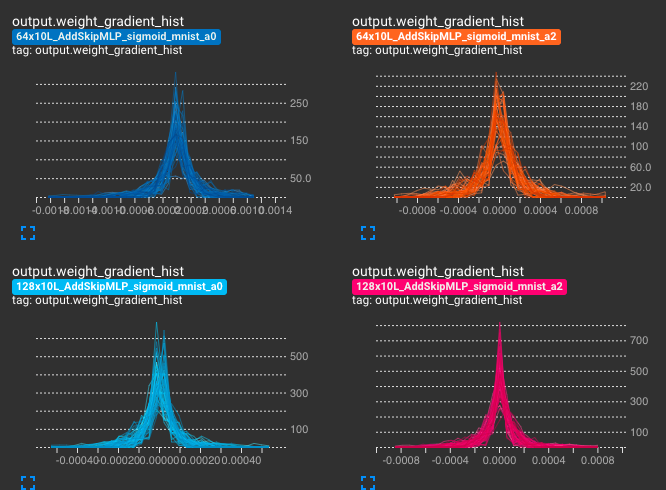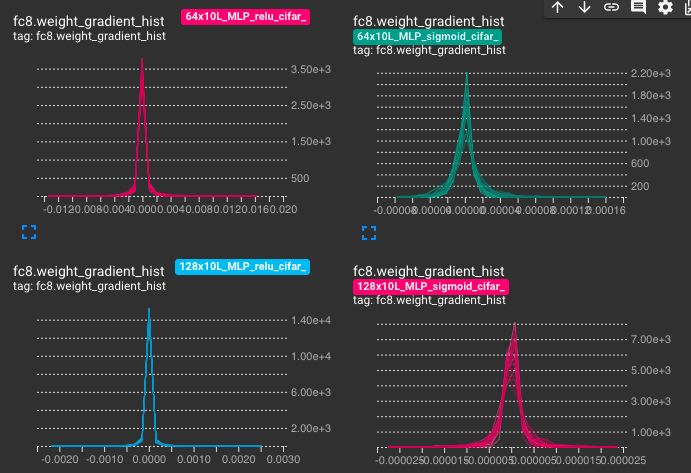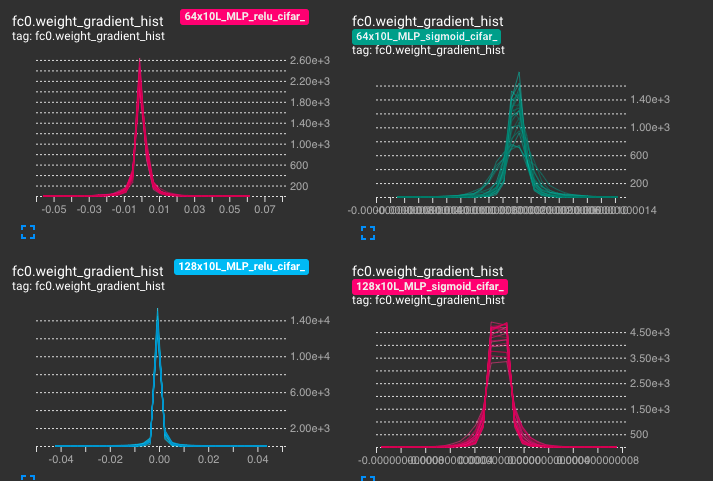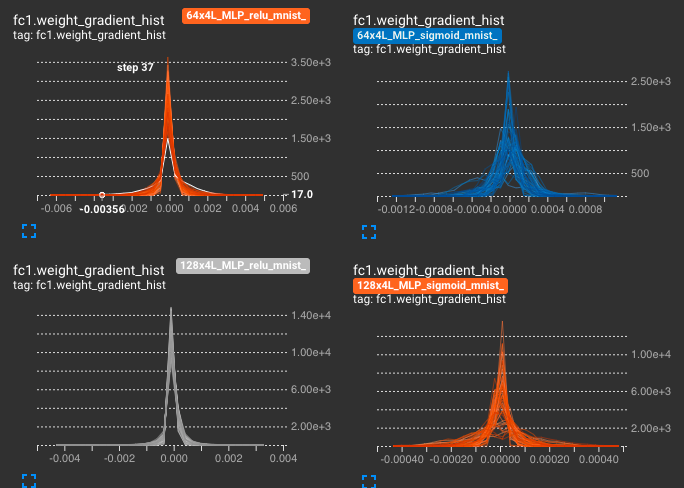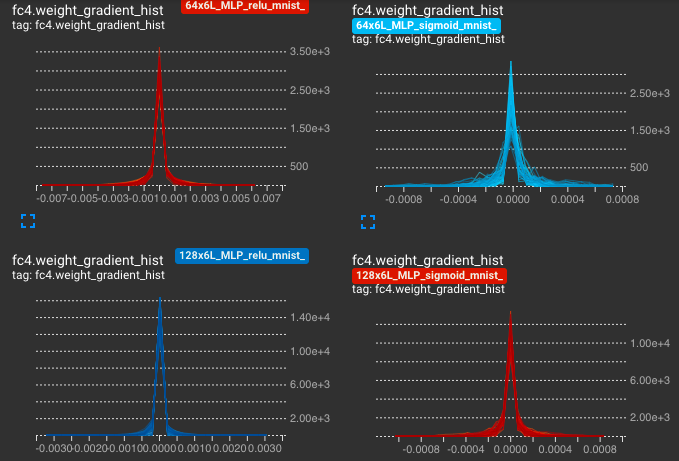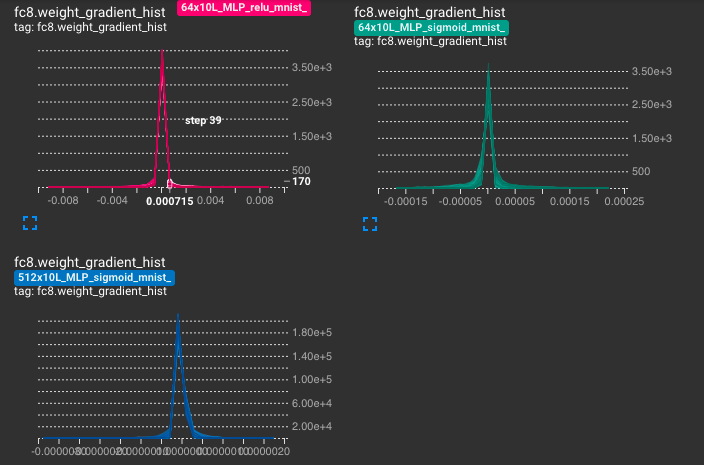

## Why do skip connections help?

Networks with skip Connections behave Like ensembles of relatively shallow
networks as they provide alternative paths for gradients to flow


They smoothen the loss surface and hence better results are obtained.

In [ ]:
#@title # Necessary Imports
import torch
import torch.nn as nn
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import tqdm
from torch.utils.data import random_split
from collections import OrderedDict
import random
import os
import numpy as np

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
#@title #Reproducibility
def set_random_seed(seed_value, use_cuda=True):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value) # Python hash buildin
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
#Set Seed 1
set_random_seed(1)

#Change MNIST to CIFAR10 for CIFAR
cv_dataset = torchvision.datasets.MNIST
dataset_name = cv_dataset.__module__.split('.')[-1]

#Split Training set into Training and Validation set
if dataset_name == "mnist":
    train_size, val_size = 50000, 10000
    transform = transforms.Compose([transforms.ToTensor()])
    image_size = (28, 28, None)
elif dataset_name == "cifar":
    train_size, val_size = 45000,5000
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    image_size = (32, 32, 3)
else:
    raise NotImplementedError

#Load Dataset
train_set = cv_dataset(
    root="./data", train=True, download=True, transform=transform
)
test_set = cv_dataset(
    root="./data", train=False, download=True, transform=transform
)

#Create Splits
train_set, valid_set = random_split(train_set,[train_size,val_size])

#Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2048, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=2048, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2048, shuffle=True)

# MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, image_shape, output_classes, hidden, activation, dropout=None):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.h, self.w, self.c = image_shape
        self.out = output_classes
        self.hidden = hidden
        self.dropout = dropout
        self.activation = activation

        # Input Layer
        if not (self.c is None):
            self.input = nn.Linear(self.h * self.w * self.c, hidden[0])
        else:
            self.input = nn.Linear(self.h * self.w, hidden[0])

        # Hidden Layers
        for layer_num, size in enumerate(self.hidden[:-1]):
            setattr(
                self,
                f"fc{layer_num}",
                nn.Linear(hidden[layer_num], hidden[layer_num + 1]),
            )

        # Dropout Layers
        if self.dropout is not None:
            self.dropout = nn.Dropout(self.dropout)

        self.output = nn.Linear(hidden[-1], self.out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(x.shape)
        if not (self.c is None):
            x = x.view(-1, self.h * self.w * self.c)
        else:
            x = x.view(-1, self.h * self.w)
        
        # print(x.shape)
        x = self.activation(self.input(x))
        if self.dropout is not None:
            x = self.dropout(x)

        for layer_num, size in enumerate(self.hidden[:-1]):
            x = self.activation(getattr(self, f"fc{layer_num}")(x))
            if self.dropout is not None:
                x = self.dropout(x)

        x = self.softmax(self.output(x))
        return x

## Additive Skip Connection

In [ ]:
class AddSkipMLP(MLP):
    def __init__(self, image_shape, output_classes, hidden, activation, skip_dict, dropout=None):
        super(AddSkipMLP, self).__init__(image_shape, output_classes, hidden, activation, dropout=None)
        self.skips = skip_dict
        self.name = "AddSkipMLP"

    def forward(self, x):
        res_skips = dict()
        
        if not (self.c is None):
            x = x.view(-1, self.h * self.w * self.c)
        else:
            x = x.view(-1, self.h * self.w)
        #fc0
        x = self.activation(self.input(x))
        if 0 in self.skips:
            res_skips[self.skips[0]]=x

        if self.dropout is not None:
            x = self.dropout(x)

        #fc{1} to fc{n-1}
        for layer_num, size in enumerate(self.hidden[:-1]):    
            if layer_num+1 in res_skips:
                x = self.activation(getattr(self, f"fc{layer_num}")(x+res_skips[layer_num+1]))
            else:
                x = self.activation(getattr(self, f"fc{layer_num}")(x))
            
            if layer_num+1 in self.skips:
                #res_skips[4]=fc0
                res_skips[self.skips[layer_num+1]]=x

            if self.dropout is not None:
                x = self.dropout(x)

        #fcn
        if len(self.hidden) in res_skips:
            x = self.softmax(self.output(x+res_skips[len(self.hidden)]))
        else:
            x = self.softmax(self.output(x))
        return x

## Concatenation Skip MLP

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_features, out_features, conc_features, activation):
        super(DenseBlock, self).__init__()
        self.skiplayer = nn.Sequential(OrderedDict([
            ('Trasition', nn.Linear(in_features=in_features + conc_features, out_features=out_features)),
            ('Activation', activation()),
            ('FC', nn.Linear(in_features=out_features, out_features=out_features)),
        ]))
    
    def forward(self, x, conc_features):
        x_ = torch.cat((x, conc_features), dim=1)
        return self.skiplayer(x_)
    
#1->3

class ConSkipMLP(nn.Module):
    def __init__(self, image_shape, hidden, output_classes, activation, skip_dict, dropout=None):
        super(ConSkipMLP, self).__init__()
        self.name = "ConSkipMLP"
        self.h, self.w, self.c = image_shape
        self.out = output_classes
        self.hidden = hidden
        self.dropout = dropout
        self.activation = activation
        self.skips = skip_dict
        self.rev_skips = {v:k for k,v in self.skips.items()}

        # Input Layer
        if not (self.c is None):
            self.input = nn.Linear(self.h * self.w * self.c, hidden[0])
        else:
            self.input = nn.Linear(self.h * self.w, hidden[0])

        # Hidden Layers
        for layer_num, size in enumerate(self.hidden[:-1]):
            if layer_num+1 in self.rev_skips:
                setattr(
                    self,
                    f"fc{layer_num}",
                    DenseBlock(hidden[layer_num], hidden[layer_num + 1], hidden[self.rev_skips[layer_num+1]], activation=activation),
                )
            else:
                setattr(
                    self,
                    f"fc{layer_num}",
                    nn.Linear(hidden[layer_num], hidden[layer_num + 1]),
                )

        # Output Layer
        last = len(self.hidden)
        if last in self.rev_skips:
            self.output = DenseBlock(hidden[-1], self.out, hidden[self.rev_skips[last]], activation=activation),
        else:
            self.output = nn.Linear(hidden[-1], self.out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        res_skips = dict()
        
        if not (self.c is None):
            x = x.view(-1, self.h * self.w * self.c)
        else:
            x = x.view(-1, self.h * self.w)
        #fc0
        x = self.activation()(self.input(x))
        if 0 in self.skips:
            res_skips[self.skips[0]]=x

        if self.dropout is not None:
            x = self.dropout(x)

        #fc{1} to fc{n-1}
        for layer_num, size in enumerate(self.hidden[:-1]):    
            if layer_num+1 in res_skips:
                x = self.activation()(getattr(self, f"fc{layer_num}")(x, res_skips[layer_num+1]))
            else:
                x = self.activation()(getattr(self, f"fc{layer_num}")(x))
            
            if layer_num+1 in self.skips:
                res_skips[self.skips[layer_num+1]]=x

            if self.dropout is not None:
                x = self.dropout(x)

        #fcn
        if len(self.hidden) in res_skips:
            x = self.softmax(self.output(x, res_skips[len(self.hidden)]))
        else:
            x = self.softmax(self.output(x))
        return x

## Train/Val/Test Function

In [ ]:
act_str = {
    nn.ReLU: "relu",
    torch.sigmoid: "sigmoid",
    torch.relu: "relu",
}

def train(model, epochs, seed=1, test=True, skip_suffix=""):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    set_random_seed(seed)
    optimizer = opt.Adam(model.parameters(), lr=2e-3)
    criterion = torch.nn.CrossEntropyLoss()
    if torch.cuda.is_available(): 
        model.cuda()

    tb = SummaryWriter(f"logs/runs/{model.hidden[0]}x{len(model.hidden)}L_{model.name}_{act_str[model.activation]}_{dataset_name}_{skip_suffix}")
    
    for epoch in tqdm.tqdm(range(epochs)):
        #***********************************************************************
        # TRAINING PART
        #***********************************************************************
        train_loss=0
        train_correct=0
        batch = 0
        for images, labels in train_loader:
            batch+=1
            images, labels = images.to(device), labels.to(device)
            preds = model(images)

            loss = criterion(preds, labels)
            train_loss += loss.item()
            correct = preds.argmax(dim=1).eq(labels).sum().item()
            train_correct += correct

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for n, p in model.named_parameters():
                if not ('bias' in n) and p.requires_grad:
                    tb.add_histogram(f"{n}_gradient_hist", p.grad, batch)
                    tb.add_scalar(f"{n}_gradient_norm", p.grad.norm().detach().cpu().item(), batch)

            tb.add_scalar("Train_Batch_Loss", loss.item(), batch)
            tb.add_scalar("Train_Batch_Accuracy", correct / images.size()[0], batch)

        tb.add_scalar("Train_Epoch_Loss", train_loss, epoch)
        tb.add_scalar("Train_Epoch_Accuracy", train_correct / len(train_set), epoch)

        #***********************************************************************
        #VALDIATION PART
        #***********************************************************************
        with torch.no_grad():
            val_loss=0
            val_correct=0
            batch = 0
            for images, labels in valid_loader:
                batch+=1
                images, labels = images.to(device), labels.to(device)
                preds = model(images)

                loss = criterion(preds, labels)
                val_loss += loss.item()
                correct = preds.argmax(dim=1).eq(labels).sum().item()
                val_correct += correct

                tb.add_scalar("Validation_Batch_Loss", loss.item(), batch)
                tb.add_scalar("Validation_Batch_Accuracy", correct / images.size()[0], batch)

            tb.add_scalar("Validation_Epoch_Loss", val_loss, epoch)
            tb.add_scalar("Validation_Epoch_Accuracy", val_correct / len(valid_set), epoch)


    #***********************************************************************
        #TEST PART
    #***********************************************************************
    if test:
        with torch.no_grad():
            test_correct=0
            batch = 0
            for images, labels in test_loader:
                batch+=1
                images, labels = images.to(device), labels.to(device)
                preds = model(images)

                loss = criterion(preds, labels)
                correct = preds.argmax(dim=1).eq(labels).sum().item()
                test_correct += correct

            print(f"Test accuracy is {(test_correct / 10000)*100}%")
    tb.close()

In [ ]:
def tb_graph(model, name):
    tb = SummaryWriter(f"logs/static/{name}")
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    tb.add_image("images", grid)
    tb.add_graph(model, images)
    tb.close()

In [ ]:
skips_io = {
    0:5,
    1:4,
}
model = ConSkipMLP(image_shape=image_size, hidden=[64]*6, activation=nn.ReLU, skip_dict=skips_io, output_classes=10)
tb_graph(model, "6L_ConSkipMLP")
#train(model=model, epochs=25, test=True)

In [ ]:
model = MLP(image_shape=image_size, hidden=[64]*6, activation=torch.relu, output_classes=10)
tb_graph(model, "6L_MLP")
#train(model=model, epochs=25, test=True)

In [ ]:
skips_io = {
    0:5,
    1:4,
}
model = AddSkipMLP(image_shape=image_size, hidden=[64]*6, activation=torch.sigmoid, skip_dict=skips_io, output_classes=10)
tb_graph(model, "6L_AddSkipMLP")
#train(model=model, epochs=25, test=True)

In [ ]:
!rm -r logs

In [ ]:
%tensorboard --logdir logs